### Pulsar BTD Classifier

# Decision Trees
![Decision tree joke](https://camo.githubusercontent.com/08b9d1f7280425a77ddf445fb40dc1e0827ea44a/68747470733a2f2f7062732e7477696d672e636f6d2f6d656469612f4231336e3256564349414130684a532e6a7067)



First we import some libraries:

In [7]:
import numpy as np   # for array stuff
import pylab as pl   # an alternative to matplotlib, for plotting stuff

We'll use the *scikit-learn* library for the decision trees in this notebook. It will be one of your best friends when dealing with machine learning tasks or issues. It has a vast range of functions, helpers, classes to pre-process data, do a transformation like PCA, split data into traning and test sets, define a classifier or learner with desired parameters, train the classifier, use the classifier to predict on a test set and then analyze how good it did. 

For the moment let's import a whole bunch of stuff from there:

In [8]:
from sklearn.ensemble import RandomForestClassifier # our classifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

This library is useful for making evaluation plots:

In [12]:
import scikitplot as skplt

This library is for data handling:

In [13]:
import pandas as pd  

Some code to control the size of figures in the notebook:

In [35]:
pl.rcParams['figure.figsize'] = [15, 10]
pl.rcParams['figure.dpi'] = 300

---

We're going to import the [HTRU2 dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2):

In [16]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip -o HTRU2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1526k  100 1526k    0     0   874k      0  0:00:01  0:00:01 --:--:--  878k


In [17]:
!unzip HTRU2.zip

Archive:  HTRU2.zip
  inflating: HTRU_2.csv              
  inflating: HTRU_2.arff             
  inflating: Readme.txt              


In [23]:
df = pd.read_csv('pulsar_data/pulsar.csv')

The first row of the CSV file tells us what the features are:

In [24]:
feature_names = df.columns.values[0:-1]
print(feature_names)

['mean_int_pf' 'std_pf' 'ex_kurt_pf' 'skew_pf' 'mean_dm' 'std_dm'
 'kurt_dm' 'skew_dm']


In [25]:
df.head()

,mean_int_pf,std_pf,ex_kurt_pf,skew_pf,mean_dm,std_dm,kurt_dm,skew_dm,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


and we can check just how much data we're dealing with:

In [26]:
# Show some information
print ('Dataset has %d rows and %d columns including features and labels'%(df.shape[0],df.shape[1]))

Dataset has 17898 rows and 9 columns including features and labels


We're going to start by separating the numerical feature data from class labels for all the candidates. To get the feature data on its own we can just strip off the column containing the class labels:

In [27]:
features = df.drop('class', axis=1)

The labels for each object tell us abut the target class and we can create an array of those data by extracting the column from the original dataset:

In [28]:
targets = df['class']

In [29]:
df['class'].value_counts()

0    16259
1     1639
Name: class, dtype: int64

Let's take a look at how the two classes are distributed in parameter space. We'll plot the value of one feature against another and colour code the data samples according to their class. This is a pretty basic plot, if you want to try creating something more fancy the [seaborn library](https://seaborn.pydata.org) is a good place to start. 

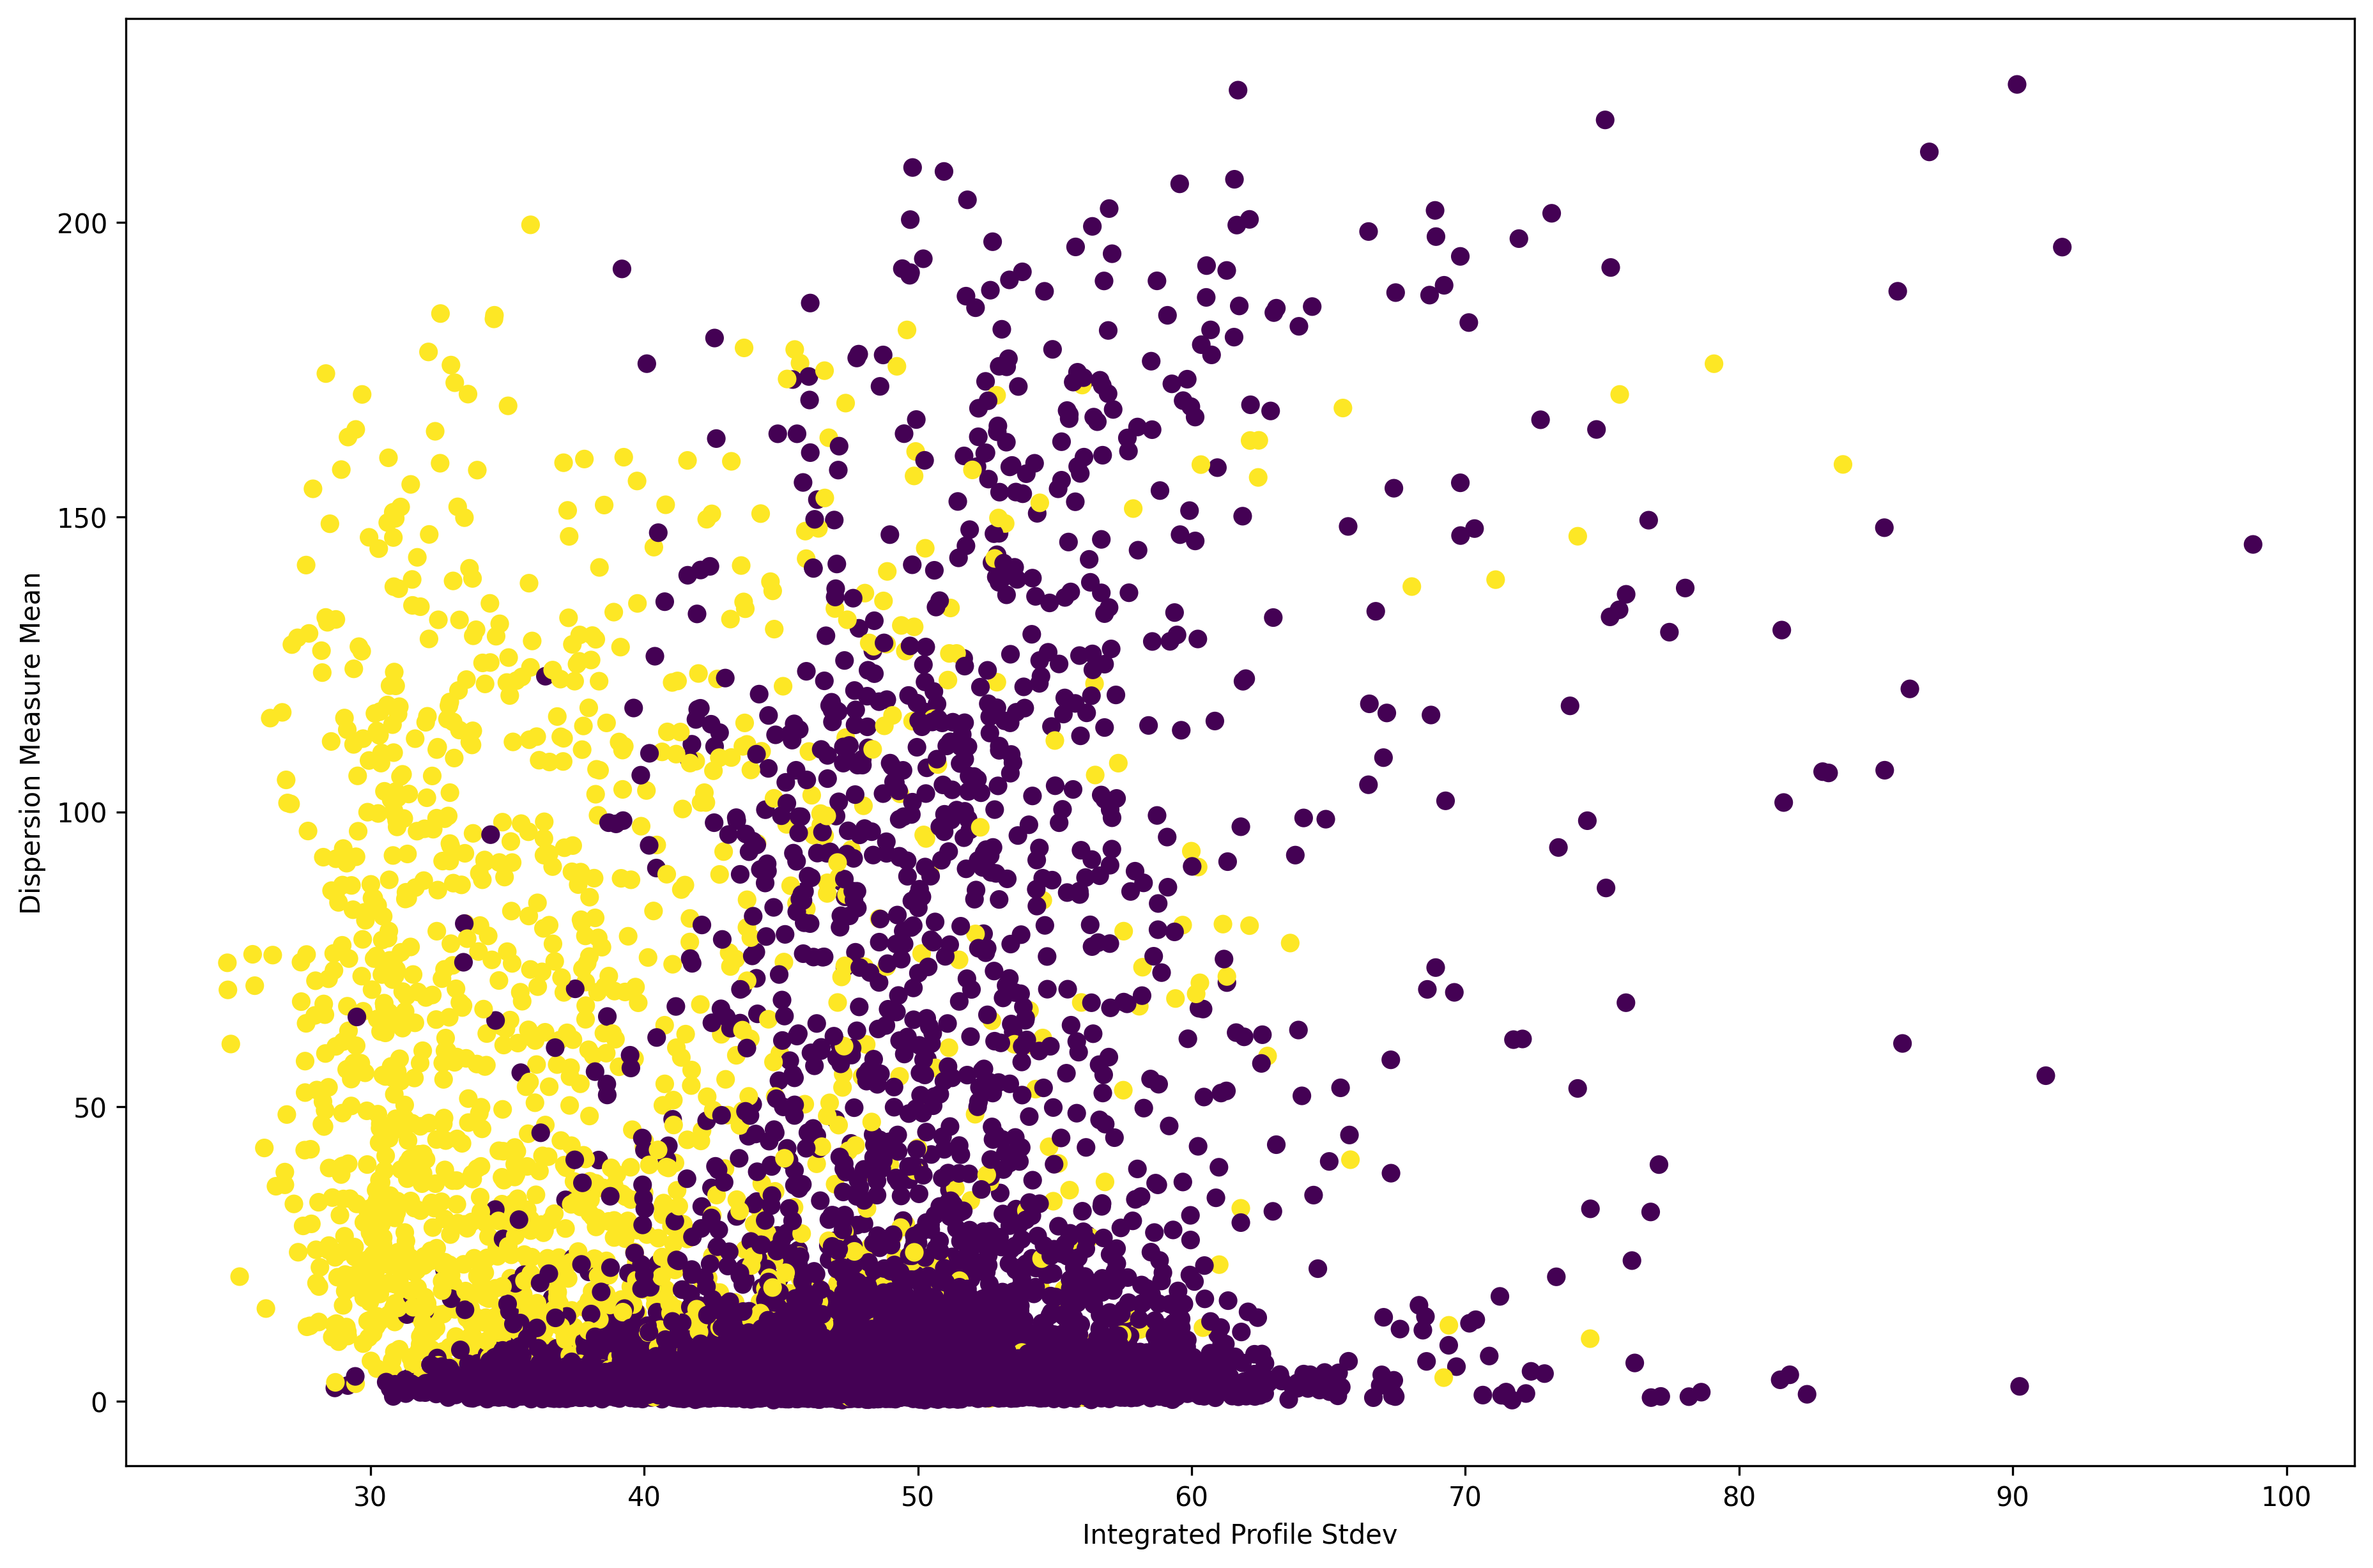

In [36]:
pl.subplot(111)
pl.scatter(df['std_pf'], df['mean_dm'],c=df['class'])
pl.xlabel('Integrated Profile Stdev')
pl.ylabel('Dispersion Measure Mean')
pl.show()

---

**Hands-on 1:** try plotting different combinations of features and see if there are any clear divisions.

---

Now we need to split our labelled data into two separate datasets: one to train the classifier and one to test the fitted machine learning model. 

To do this we can use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the [scikit_learn](https://scikit-learn.org) library:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, random_state=66)

---

**Exercise 2:** Once you've run through the tutorial, come back to this point and see what difference changing the relative size of your train:test datasets makes.

---


At this point we now have our dataset in the suitable state to start training our classifier. 

To start with we need to initiate the random forest classifier from [scikit_learn]():

In [41]:
RFC = RandomForestClassifier(n_jobs=2,n_estimators=10)

...and we can immediately fit the machine learning model to our training data:

In [42]:
RFC.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=2)

---

**Exercise 3:** You could try changing the split criterion from the "gini" ([Gini impurity](https://victorzhou.com/blog/gini-impurity/)) to "entropy" (information gain). Does it make a difference?

---

We can then used the trained classifier to predict the label for the test data that we split out earlier:

In [43]:
rfc_predict = RFC.predict(X_test)

So how did we do? We need to evaluate the performance of our classifier.

A good first step is to evaluate the [cross-validation](https://www.openml.org/a/estimation-procedures/1). This will tell us how well our machine learning model *generalises*, i.e. whether we have over-fitted the training data.

In [44]:
rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')

Let's print out the various evaluation criteria:

In [45]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5325   37]
 [  94  451]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.92      0.83      0.87       545

    accuracy                           0.98      5907
   macro avg       0.95      0.91      0.93      5907
weighted avg       0.98      0.98      0.98      5907



=== All AUC Scores ===
[0.91832606 0.94407007 0.95280578 0.96531028 0.96925344 0.94367069
 0.95485705 0.95577581 0.96456546 0.96729644]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9535931059501722


We can make a more visual representation of the confusion matrix using the [scikit-plot]() library. To do this we need to know the predictions from our cross validation, rather than the Area Under Curve ([AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)) value:

In [46]:
predictions = cross_val_predict(RFC, features, targets, cv=2)

<AxesSubplot: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

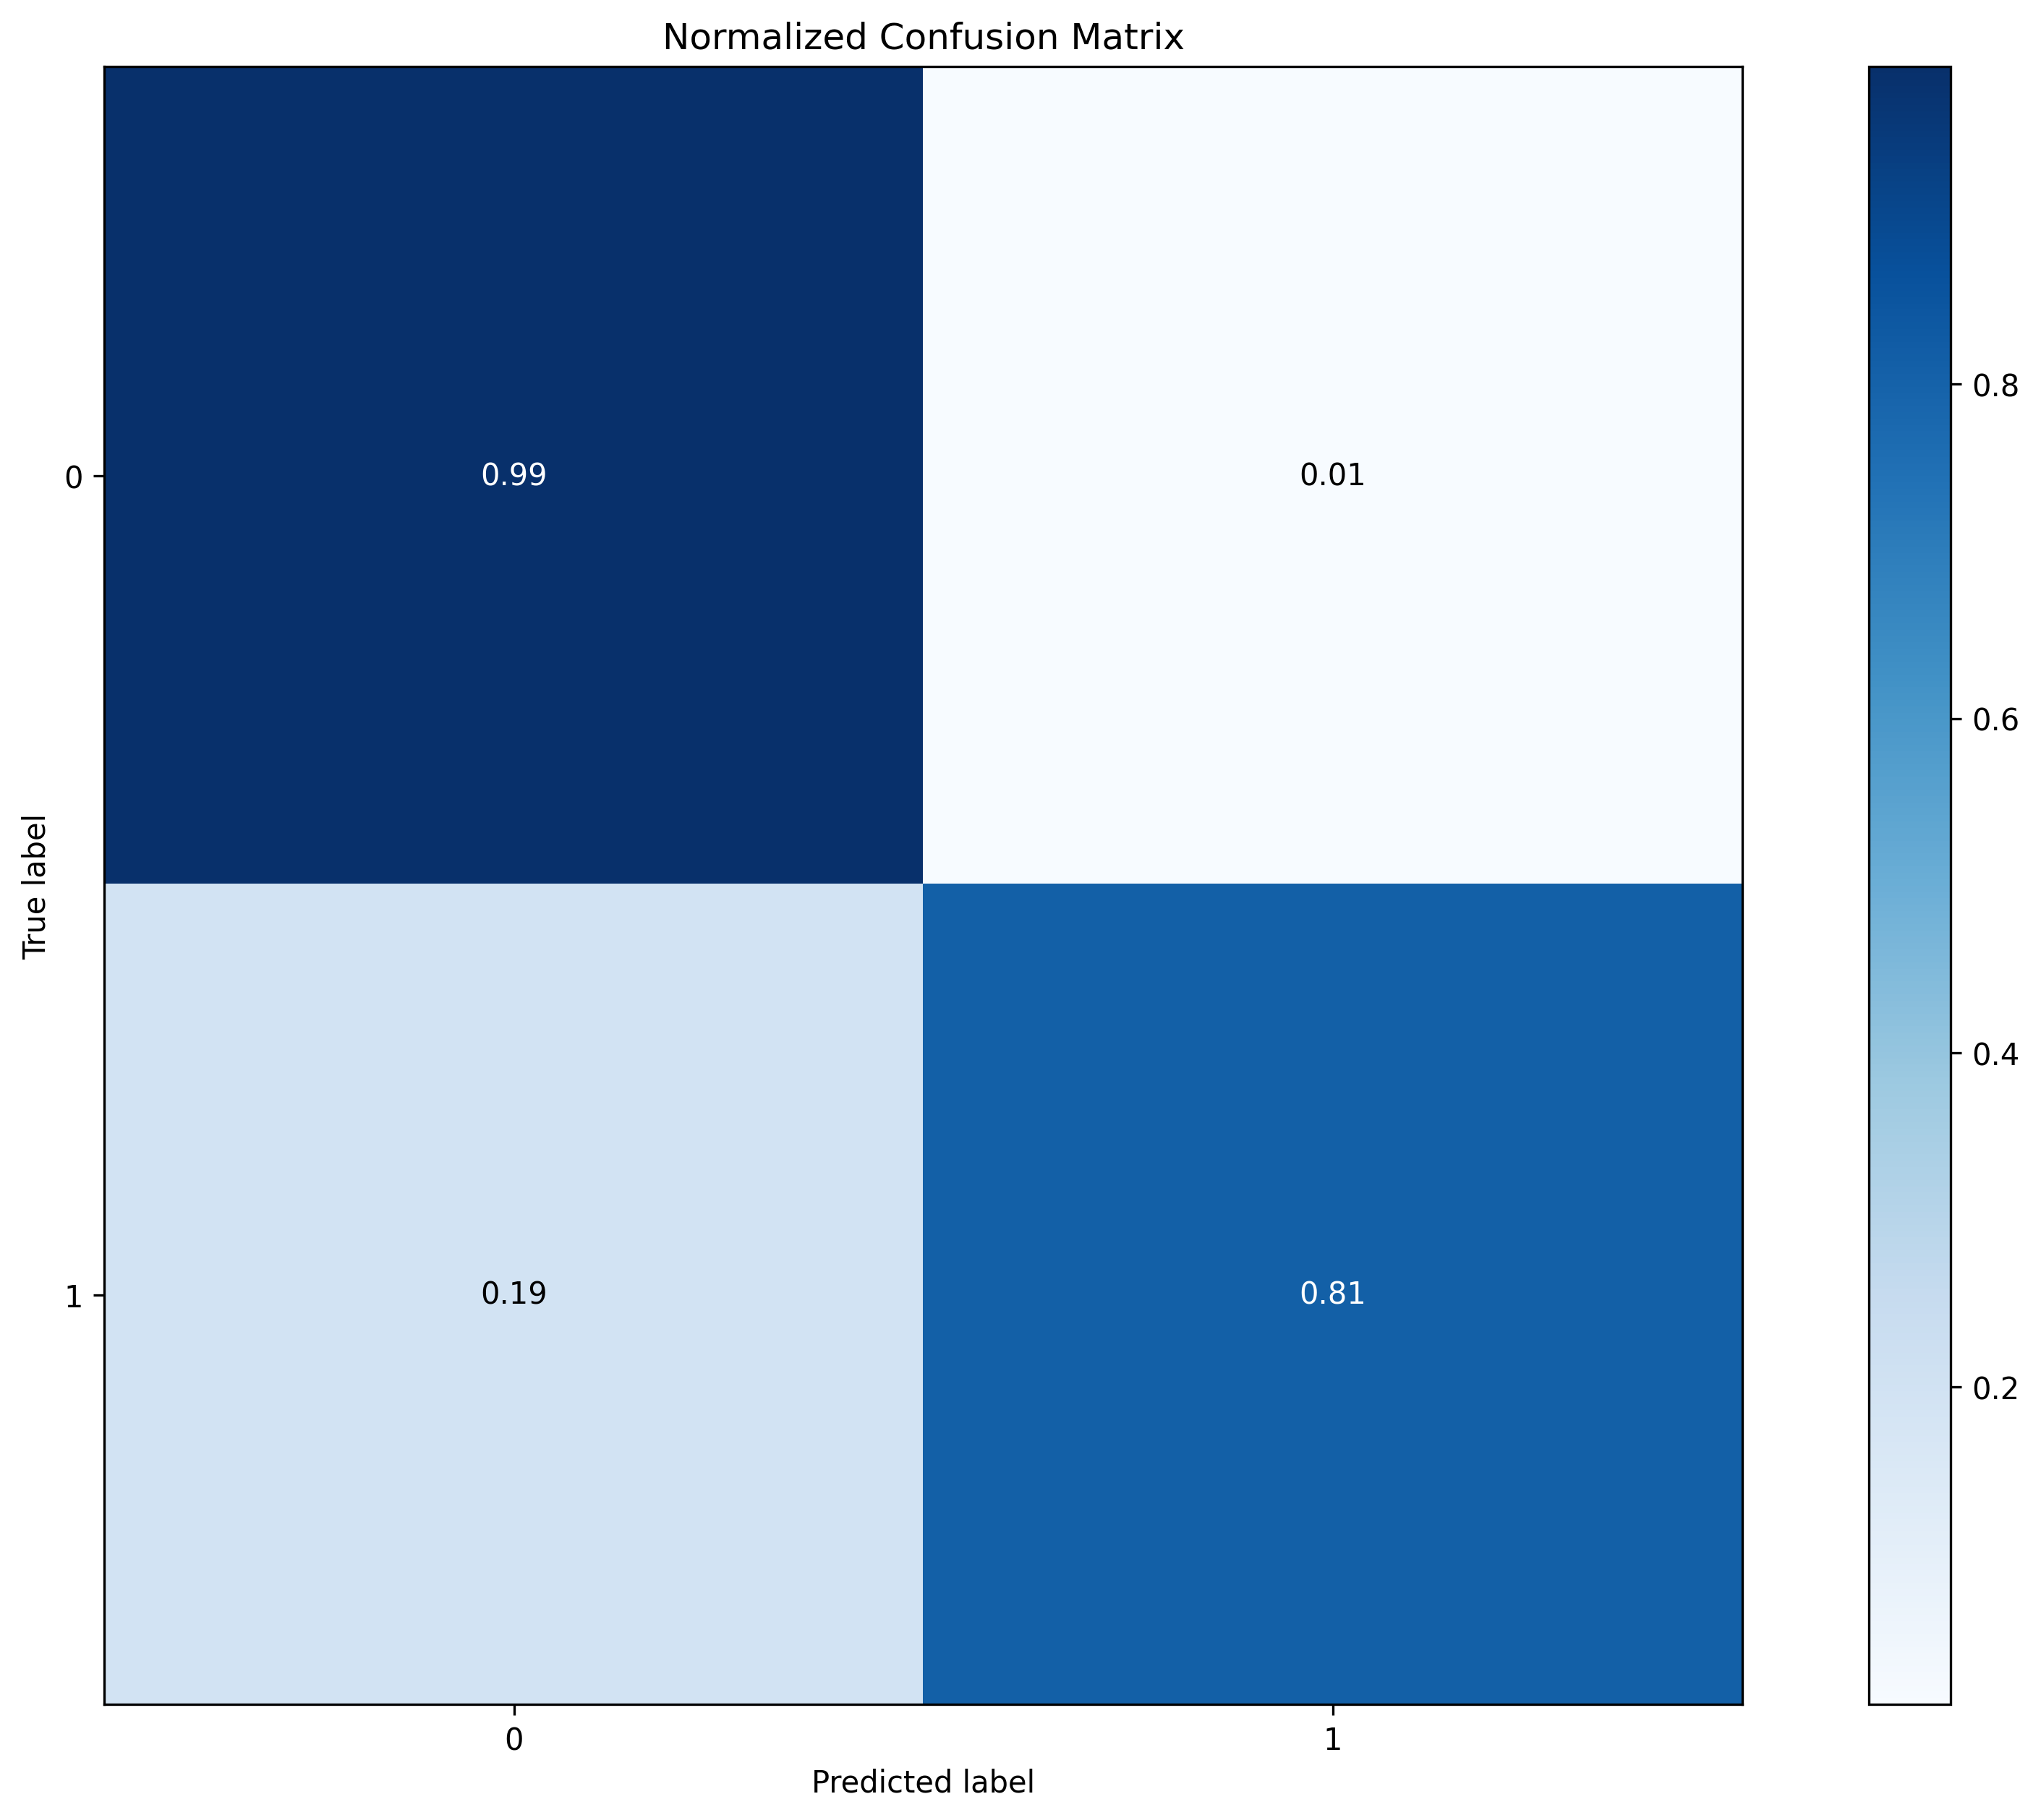

In [47]:
skplt.metrics.plot_confusion_matrix(targets, predictions, normalize=True)

To plot the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) we need to find the probabilities for each target class separately. We can do this with the [predict_proba]() function:

In [48]:
probas = RFC.predict_proba(X_test)

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

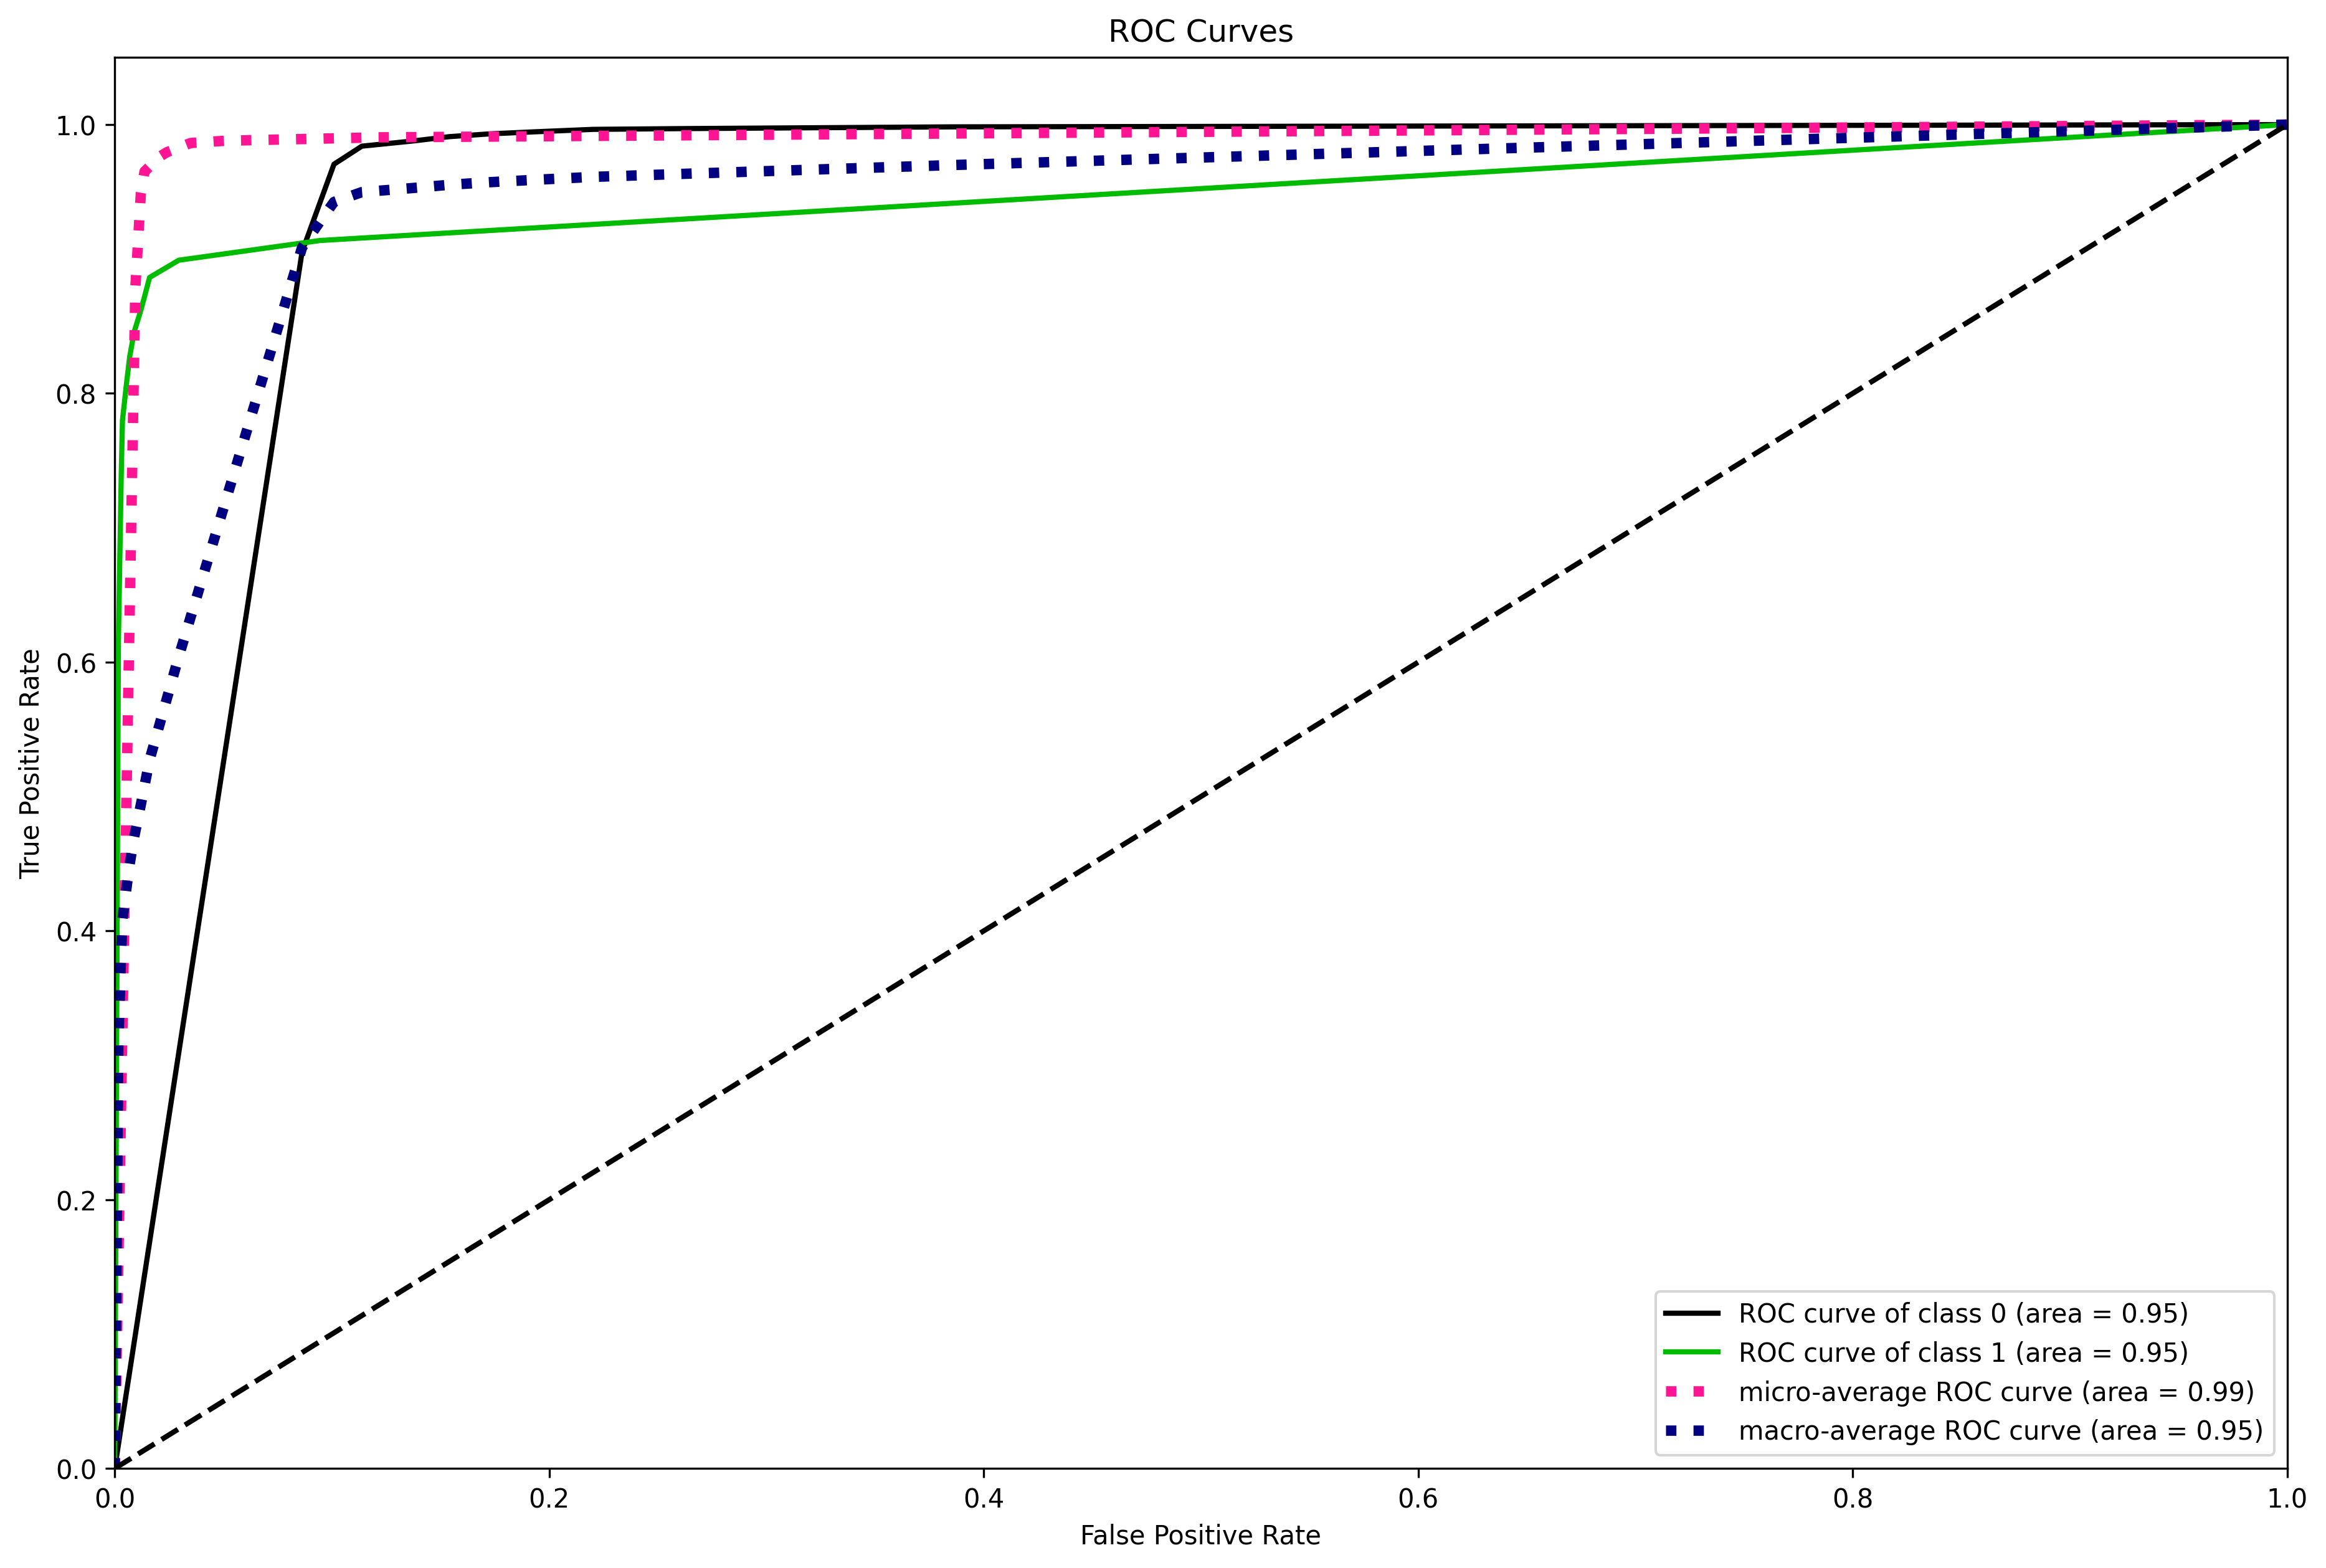

In [49]:
skplt.metrics.plot_roc(y_test, probas)

In a balanced data set there should be no difference between the micro-average ROC curve and the macro-average ROC curve. In the case where there is a class imbalance (like here), if the **macro** ROC curve is *lower* than the micro-ROC curve then there are more cases of mis-classification in minority class. [Longer description here](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html)

---

**Exercise 4:** What is the ROC curve here telling us?

---

**Exercise 5:** What is the difference between the [RFC.predict( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) function and the [RFC.predict_proba( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) function?

---




We can use the output of the RFC.predict_proba( ) function to plot a Precision-Recall Curve. Recall that,

$$Precision = \frac{TP}{TP+FP},$$

$$Recall = \frac {TP}{TP+FN}.$$

<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

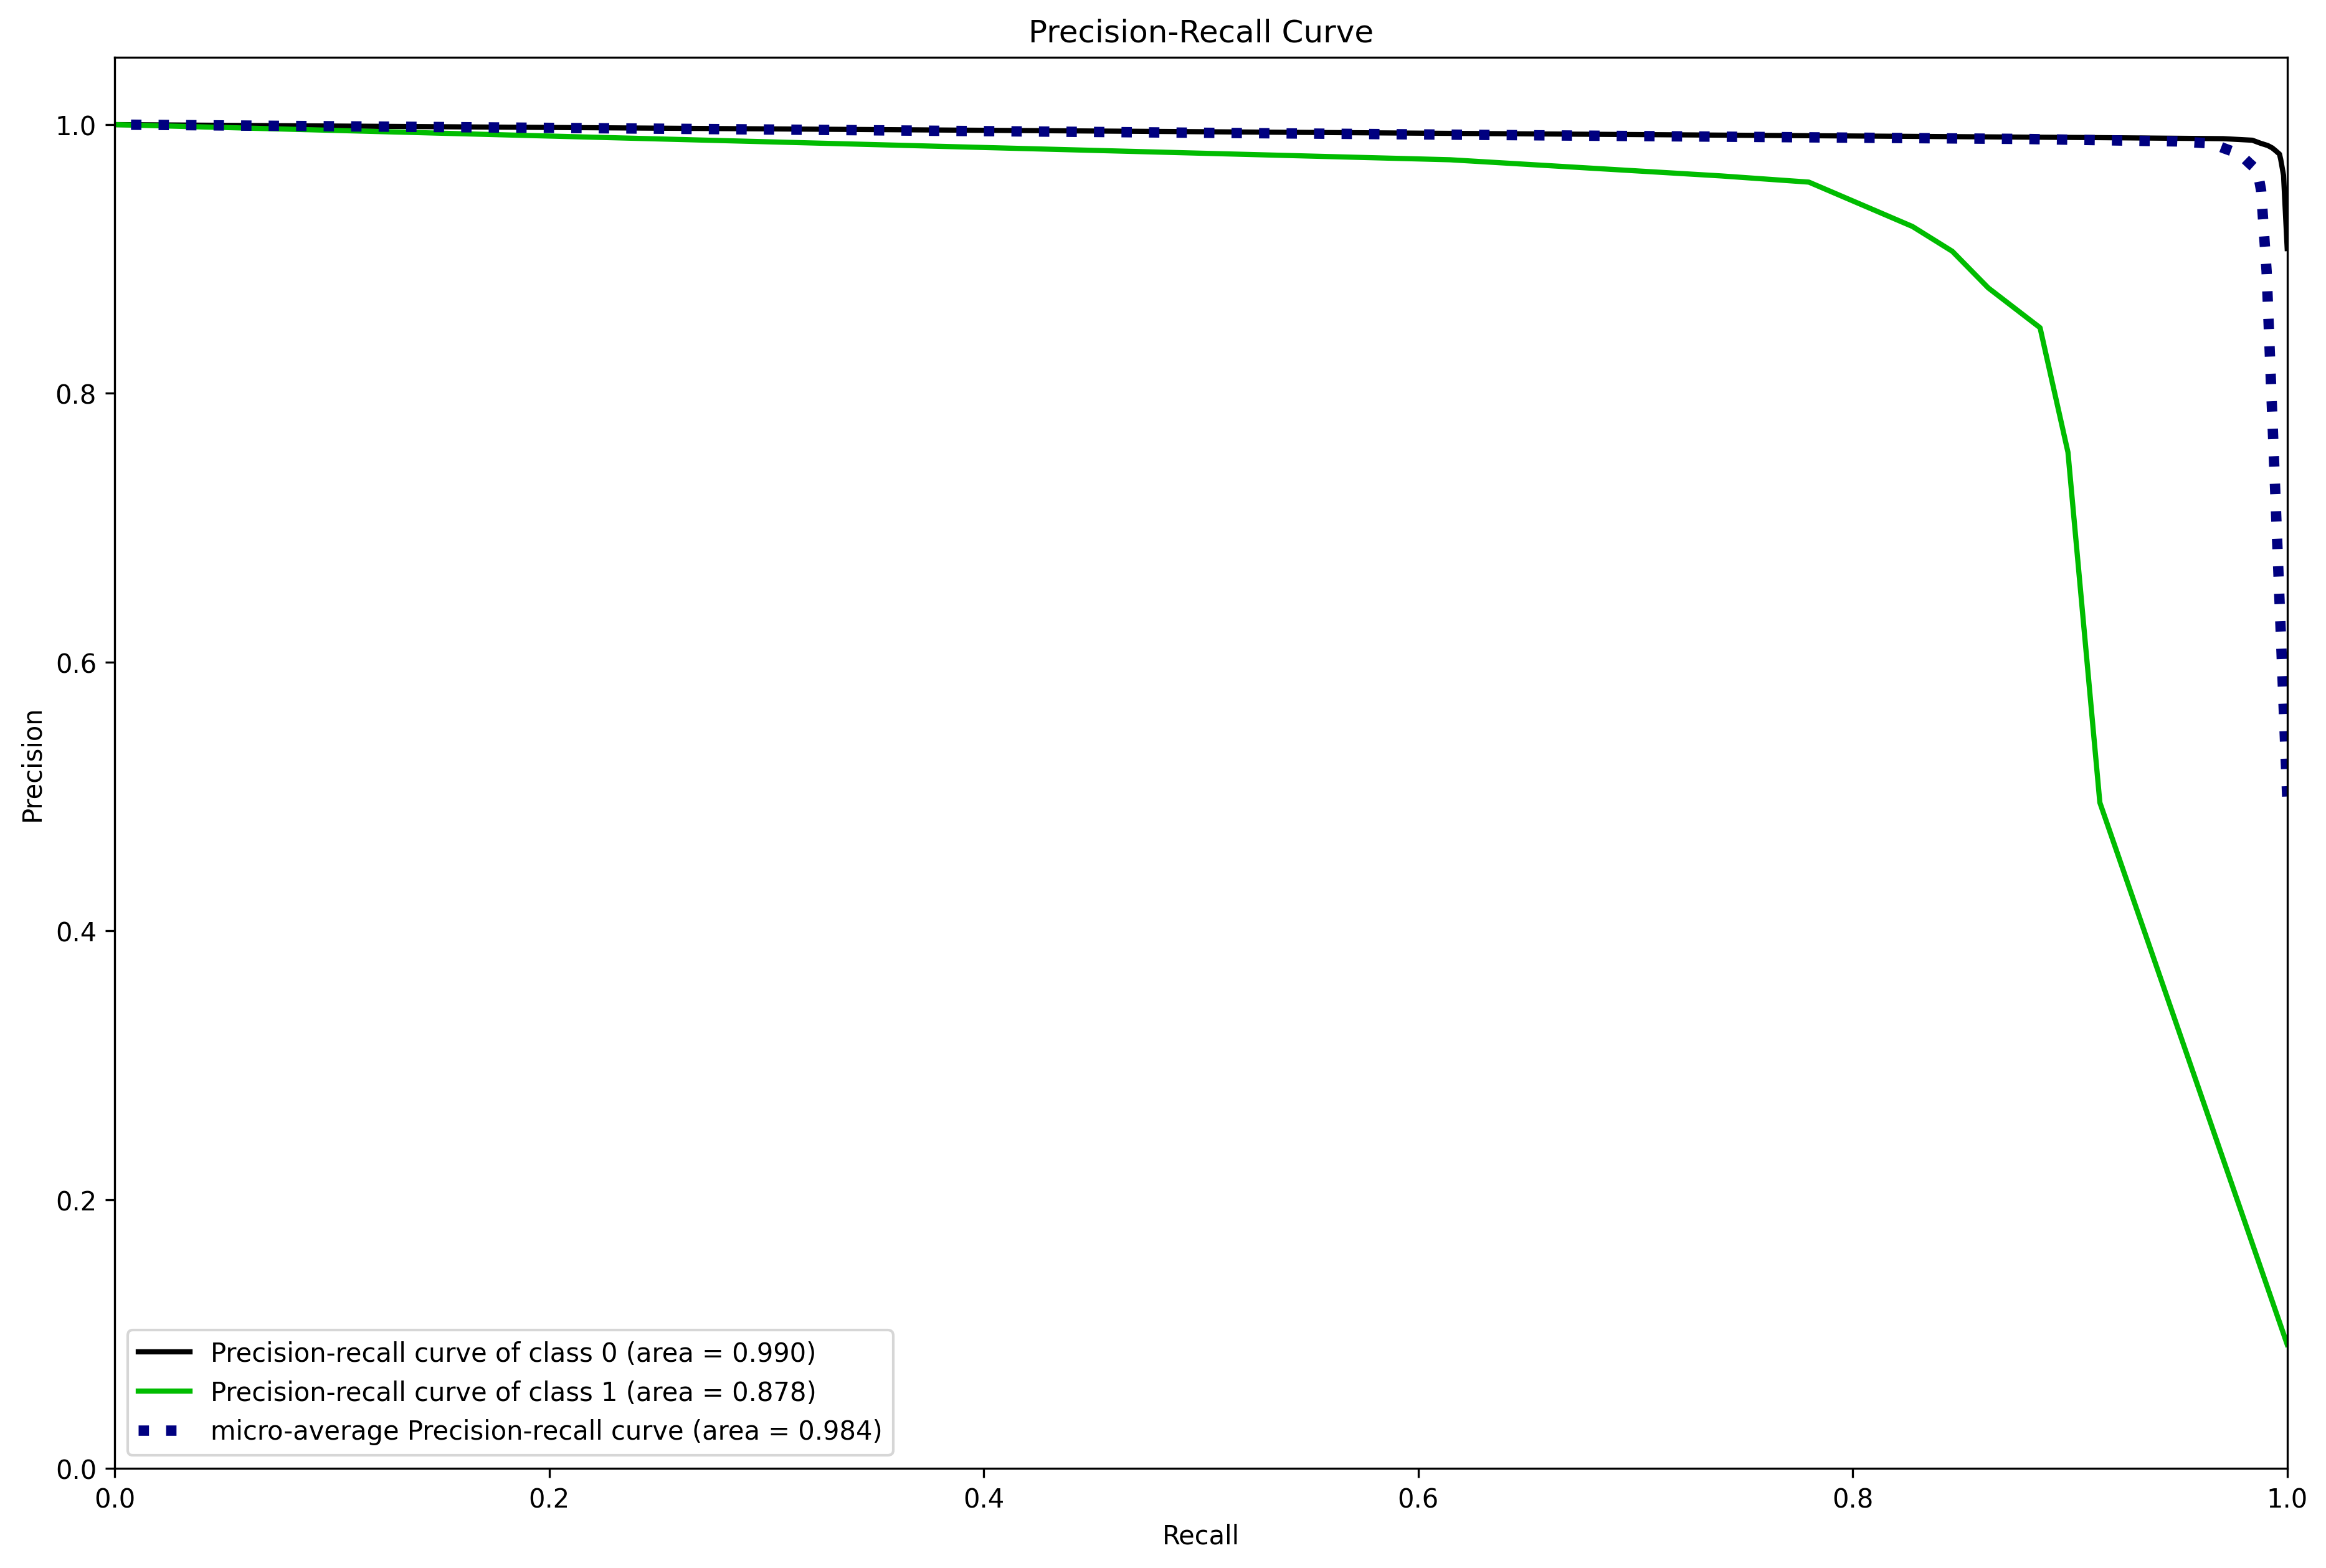

In [50]:
skplt.metrics.plot_precision_recall(y_test, probas)

When we initiated the random forest classifier we picked a value for the number of trees in our forest - but how do we know that this is the best possible value? 

We can use a "grid search" to loop through different options (e.g. number of trees, number of features for each tree, maximum depth of a tree) and tell us which one performs best.

In [51]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adrianodif/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

{'n_estimators': 733, 'max_features': 'sqrt', 'max_depth': 260}


We can then re-run our training with the optimal parameters.

---

**Exercise 6:** Can you re-write the first line of Python in the next cell so that it automatically uses the best parameters?

---

In [52]:
rfc = RandomForestClassifier(n_estimators=2000, max_depth=100, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = RFC.predict(X_test)
rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

[CV] END max_depth=100, max_features=auto, n_estimators=1366; total time=  20.8s
[CV] END max_depth=None, max_features=sqrt, n_estimators=733; total time=  11.1s
[CV] END max_depth=180, max_features=auto, n_estimators=1155; total time=  18.2s
[CV] END max_depth=420, max_features=auto, n_estimators=1788; total time=  33.5s
[CV] END max_depth=100, max_features=sqrt, n_estimators=2000; total time=  35.1s
[CV] END max_depth=260, max_features=sqrt, n_estimators=1366; total time=  23.2s
[CV] END max_depth=100, max_features=sqrt, n_estimators=1788; total time=  30.2s
[CV] END max_depth=420, max_features=sqrt, n_estimators=1155; total time=  19.8s
[CV] END max_depth=220, max_features=auto, n_estimators=1366; total time=  22.9s
[CV] END .max_depth=220, max_features=auto, n_estimators=100; total time=   1.5s
[CV] END .max_depth=500, max_features=auto, n_estimators=944; total time=  15.5s
[CV] END max_depth=500, max_features=auto, n_estimators=1577; total time=  26.2s
[CV] END max_depth=500, max_

=== Confusion Matrix ===
[[5325   37]
 [  94  451]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.92      0.83      0.87       545

    accuracy                           0.98      5907
   macro avg       0.95      0.91      0.93      5907
weighted avg       0.98      0.98      0.98      5907



=== All AUC Scores ===
[0.91757605 0.94728947 0.96209087 0.96294213 0.96616716 0.95061951
 0.96337713 0.95427204 0.96441831 0.95549906]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.954425174008465


Let's take a look at the relative importance of the different features that we fed to our classifier:

In [53]:
importances = RFC.feature_importances_
indices = np.argsort(importances)

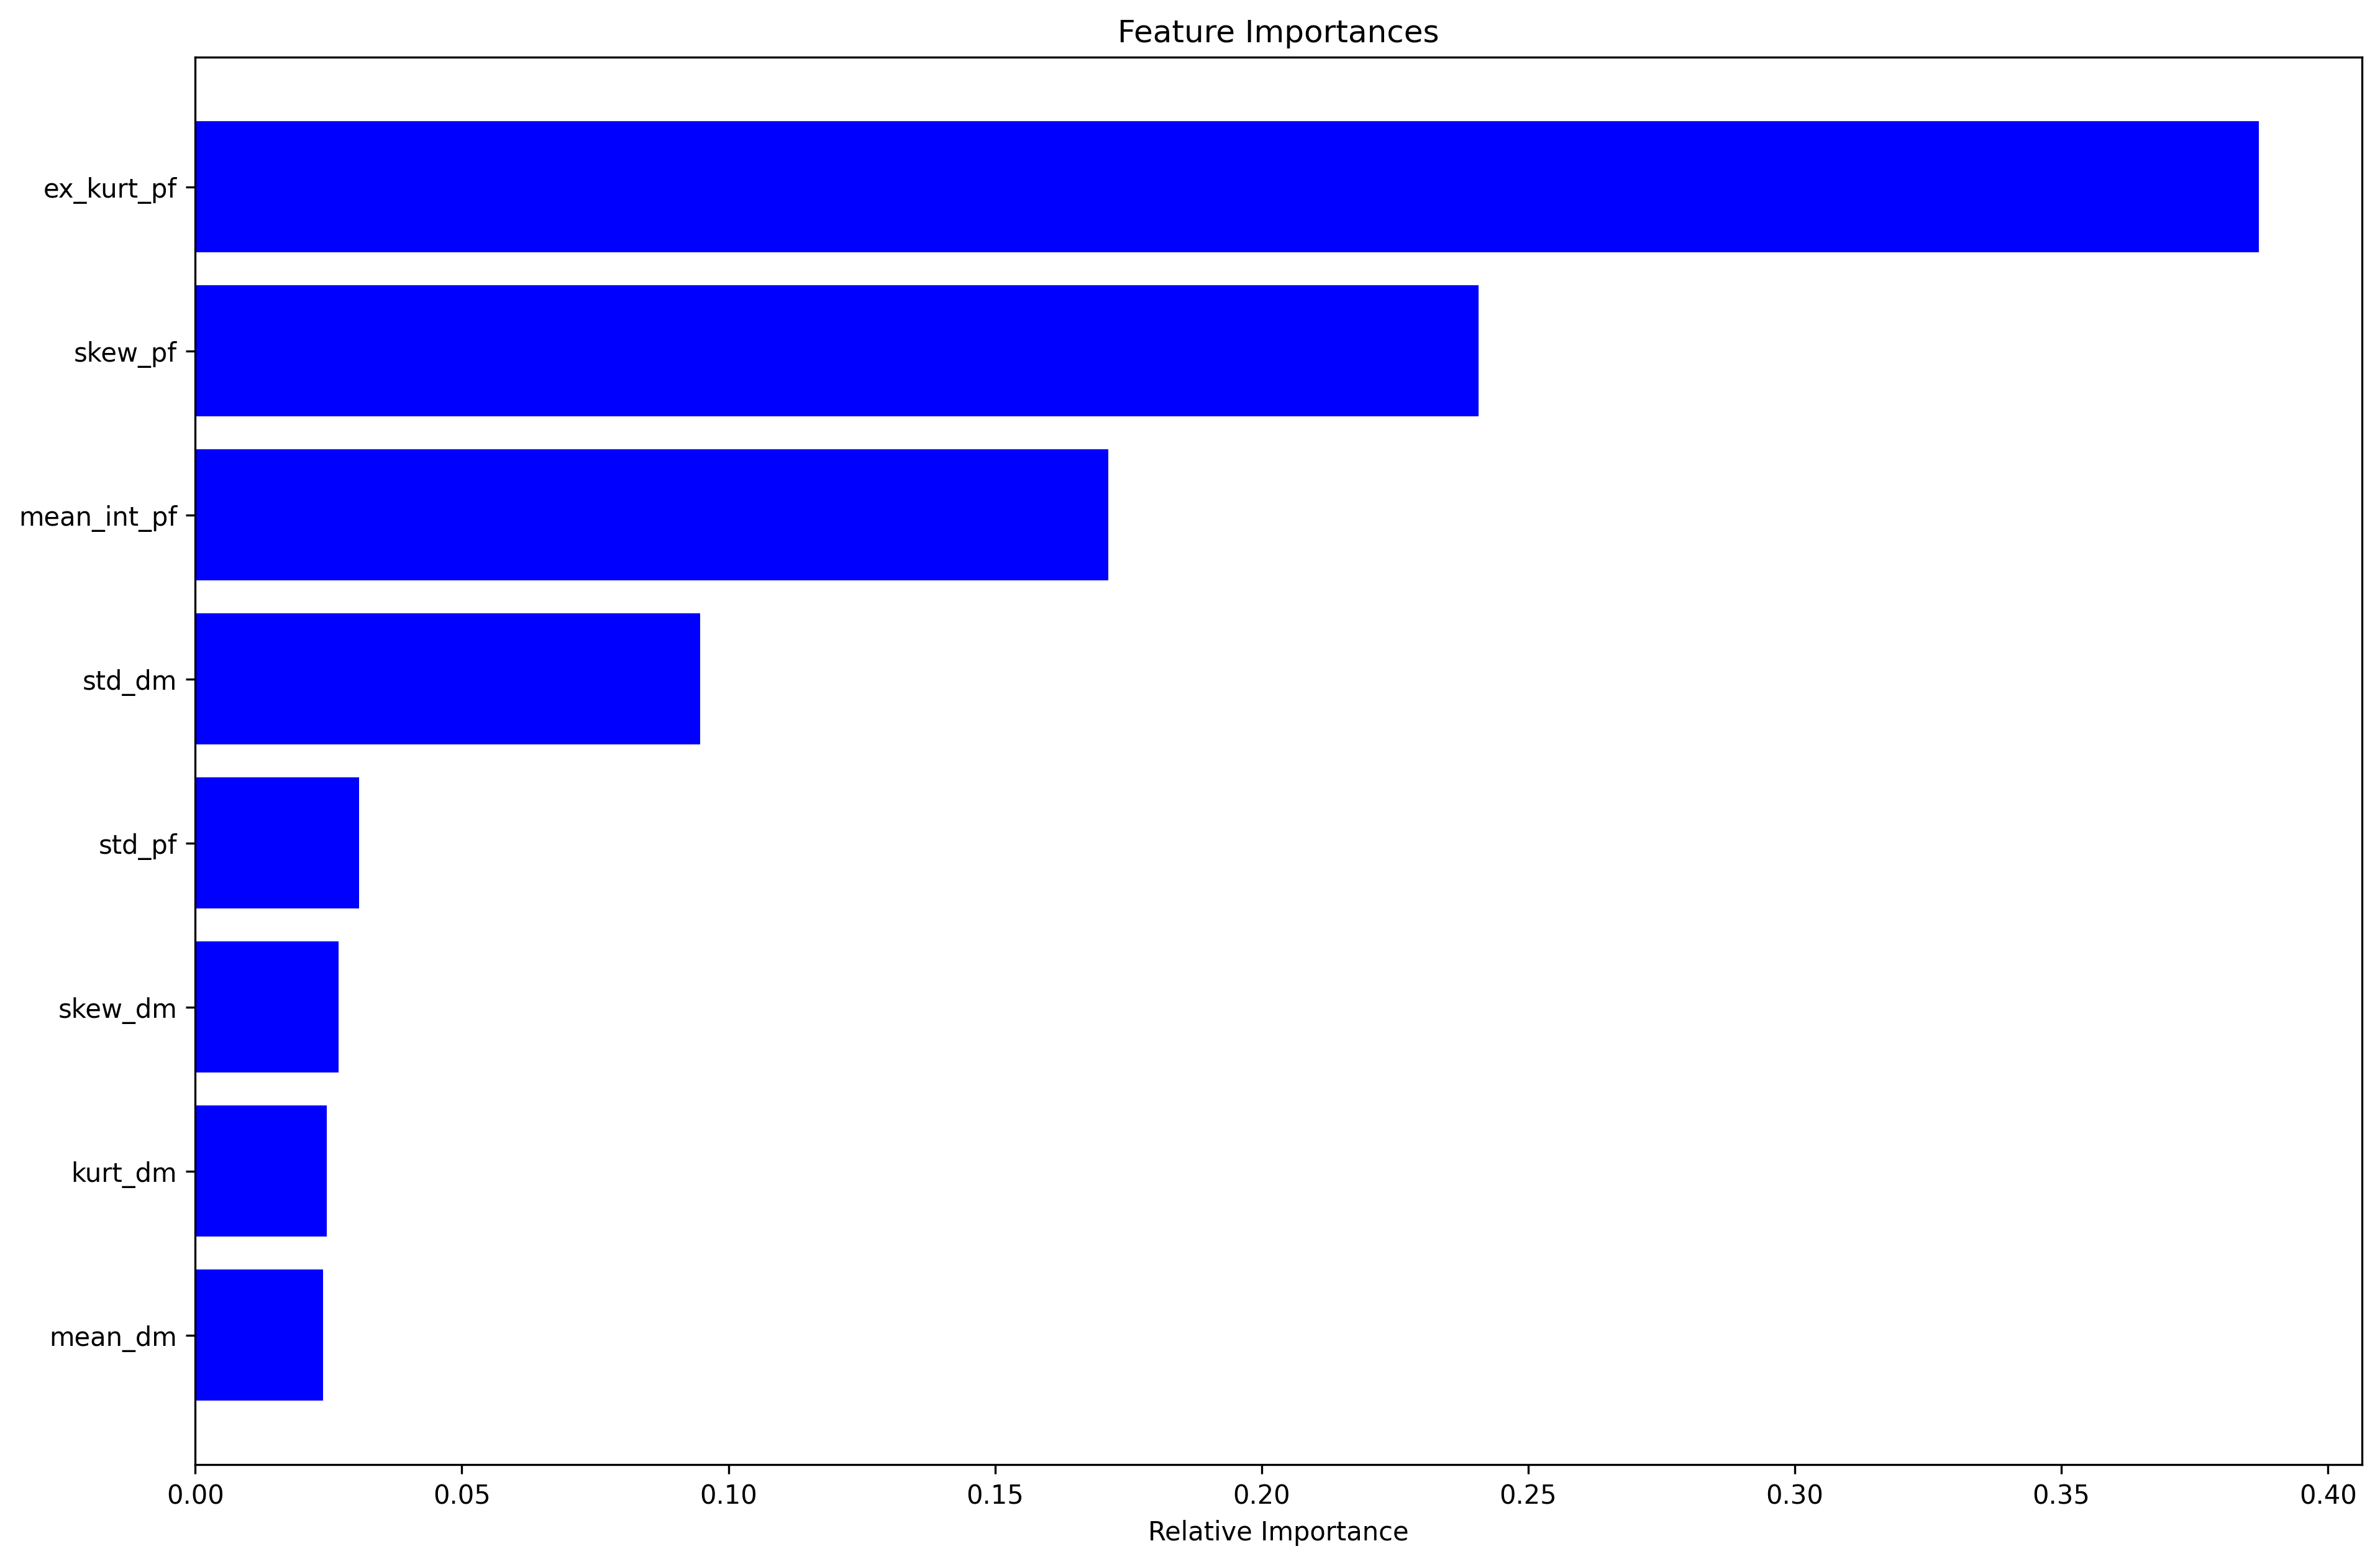

In [54]:
pl.figure(1)
pl.title('Feature Importances')
pl.barh(range(len(indices)), importances[indices], color='b', align='center')
pl.yticks(range(len(indices)), feature_names[indices])
pl.xlabel('Relative Importance')
 
pl.show()

---

**Exercise 7:** How do our results compare to the [results from the GH-VFDT classifier](https://www.research.manchester.ac.uk/portal/files/36794595/MNRAS_2016_Lyon_1104_23.pdf)?

---